<a href="https://colab.research.google.com/github/AlexandreLarget/tensorflow_projects/blob/main/11_preparation_to_TF_certificate_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image classification: Mnist

In [ ]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-71760361-8325-e3fe-c5df-fa5385e61fc4)


## Discover and visualize the datas

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np

In [ ]:
(train_data, test_data), info = tfds.load("mnist", 
                     split=["train", "test"],
                     shuffle_files=True,
                     as_supervised=True, 
                     with_info=True)

Dl Completed...:   0%|          | 0/4 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to ~/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


In [ ]:
class_names = info.features["label"].names
class_names[:10], len(class_names)

(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], 10)

In [ ]:
info.features

FeaturesDict({
    'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
})

In [ ]:
train_data

<PrefetchDataset element_spec=(TensorSpec(shape=(28, 28, 1), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [ ]:
train_one_sample = train_data.take(1)

In [ ]:
train_one_sample

<TakeDataset element_spec=(TensorSpec(shape=(28, 28, 1), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [ ]:
for image, label in train_one_sample:
  print(f"Image shape: {image.shape}")
  print(f"Image Dtype: {image.dtype}")
  print(f"Target class: {label}")
  print(f"Target label: {class_names[label]}")

Image shape: (28, 28, 1)
Image Dtype: <dtype: 'uint8'>
Target class: 4
Target label: 4


In [ ]:
image.shape, image.ndim

(TensorShape([28, 28, 1]), 3)

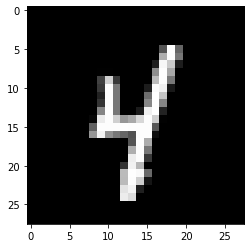

In [ ]:
import matplotlib.pyplot as plt
image = tf.squeeze(image)
plt.imshow(image, cmap='gray')

In [ ]:
def montre_une_image(dataset):
  data = dataset.shuffle(int(len(dataset)/100))
  sample = data.take(1)

  for image, label in sample:
    print(f"Image shape: {image.shape}")
    print(f"Image dtype: {image.dtype}")
    print(f"Label num: {label}")
    print(f"Label str: {class_names[label]}")

  image = tf.squeeze(image)
  plt.imshow(image)
  plt.axis(False)

Image shape: (28, 28, 1)
Image dtype: <dtype: 'uint8'>
Label num: 9
Label str: 9


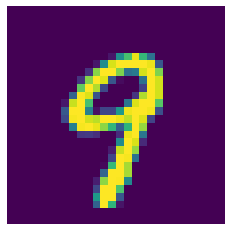

In [ ]:
montre_une_image(train_data)

## Data preprocessing

In [ ]:
def preprocessing_images(image, label, img_size=28):
  """
  Converts images datatypes from uint8 to float32 and reshape them to [img_shape, img_shape, 3]
  """
  image = tf.image.resize(image, [img_size, img_size])
  image = image / 255
  return tf.cast(image, tf.float32), label

In [ ]:
train_data = train_data.map(map_func=preprocessing_images, num_parallel_calls=tf.data.AUTOTUNE)
test_data = test_data.map(preprocessing_images, num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
train_data = train_data.shuffle(buffer_size=1000).batch(32).prefetch(tf.data.AUTOTUNE)
test_data = test_data.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
train_data

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

## Model 1: Conv 2D

In [ ]:
# Create the model
from tensorflow.keras import layers

inputs = layers.Input(shape=(28, 28, 1), dtype="float32")
x = layers.Conv2D(filters=16, kernel_size=3, activation="relu")(inputs)
x = layers.Conv2D(filters=16, kernel_size=3, activation="relu")(x)
x = layers.Conv2D(filters=16, kernel_size=3, activation="relu")(x)
x = layers.Conv2D(filters=16, kernel_size=3, activation="relu")(x)
x = layers.Conv2D(filters=16, kernel_size=3, activation="relu")(x)
x = layers.Conv2D(filters=16, kernel_size=3, activation="relu")(x)
x = layers.Conv2D(filters=16, kernel_size=3, activation="relu")(x)
x = layers.Conv2D(filters=16, kernel_size=3, activation="relu")(x)
x = layers.Conv2D(filters=16, kernel_size=3, activation="relu")(x)
x = layers.Conv2D(filters=16, kernel_size=3, activation="relu")(x)
x = layers.GlobalAvgPool2D()(x)
x = layers.Dense(64, activation="relu")(x)
output = layers.Dense(len(class_names), activation="softmax")(x)

model_1 = tf.keras.Model(inputs, output)

In [ ]:
# Compile
model_1.compile(loss="sparse_categorical_crossentropy",
                optimizer="Adam",
                metrics=["accuracy"])

In [ ]:
# Fit the model
model_1.fit(train_data,
            epochs=10,
            validation_data=test_data,
            verbose=1,
            callbacks=[tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                            verbose=1,
                                                            patience=2)])

Epoch 1/10
1875/1875 [==============================] - 37s 12ms/step - loss: 0.4090 - accuracy: 0.8646 - val_loss: 0.0974 - val_accuracy: 0.9673 - lr: 0.0010
Epoch 2/10
1875/1875 [==============================] - 18s 9ms/step - loss: 0.0992 - accuracy: 0.9702 - val_loss: 0.0542 - val_accuracy: 0.9834 - lr: 0.0010
Epoch 3/10
1875/1875 [==============================] - 17s 9ms/step - loss: 0.0757 - accuracy: 0.9766 - val_loss: 0.1073 - val_accuracy: 0.9674 - lr: 0.0010
Epoch 4/10
1874/1875 [============================>.] - ETA: 0s - loss: 0.0633 - accuracy: 0.9807
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
1875/1875 [==============================] - 19s 10ms/step - loss: 0.0633 - accuracy: 0.9807 - val_loss: 0.0609 - val_accuracy: 0.9809 - lr: 0.0010
Epoch 5/10
1875/1875 [==============================] - 18s 10ms/step - loss: 0.0315 - accuracy: 0.9898 - val_loss: 0.0305 - val_accuracy: 0.9900 - lr: 1.0000e-04
Epoch 6/10
1875/1875 [=================

In [ ]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 26, 26, 16)        160       
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 16)        2320      
                                                                 
 conv2d_2 (Conv2D)           (None, 22, 22, 16)        2320      
                                                                 
 conv2d_3 (Conv2D)           (None, 20, 20, 16)        2320      
                                                                 
 conv2d_4 (Conv2D)           (None, 18, 18, 16)        2320      
                                                                 
 conv2d_5 (Conv2D)           (None, 16, 16, 16)        2320  